In [22]:
from o3fire.photochemical_age import bimolecular_rate_law
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
%matplotlib inline

In [18]:
def rma_regression_slope(df, x, y):
    slope_a = sm.OLS(df[y], df[x], missing='drop').fit().params[0]
    slope_b = sm.OLS(df[x], df[y], missing='drop').fit().params[0]
    
    slope_b = 1 / slope_b
    # Check if correlated in same direction
    if np.sign(slope_a) != np.sign(slope_b):
        raise RuntimeError('Type I regressions of opposite sign.')
    
    # Compute Reduced Major Axis Slope
    slope = np.sign(slope_a) * np.sqrt(slope_a * slope_b)
    
    # Compute r
    r = np.sign(slope_a) * np.sqrt(slope_a / slope_b)
    
    return slope, r**2

# Load Data

In [3]:
df = pd.read_csv('../../data/processed/complete_data.csv', parse_dates=['timestamp'], index_col='timestamp')

/tmp/ipykernel_354684/4140673560.py:1: DtypeWarning: Columns (195) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/processed/complete_data.csv', parse_dates=['timestamp'], index_col='timestamp')


In [2]:
firex_measurements_df = pd.read_csv('../../data/final_measurement_lists/final_firex_measurement_list.csv')

# Plot

### Figure S5

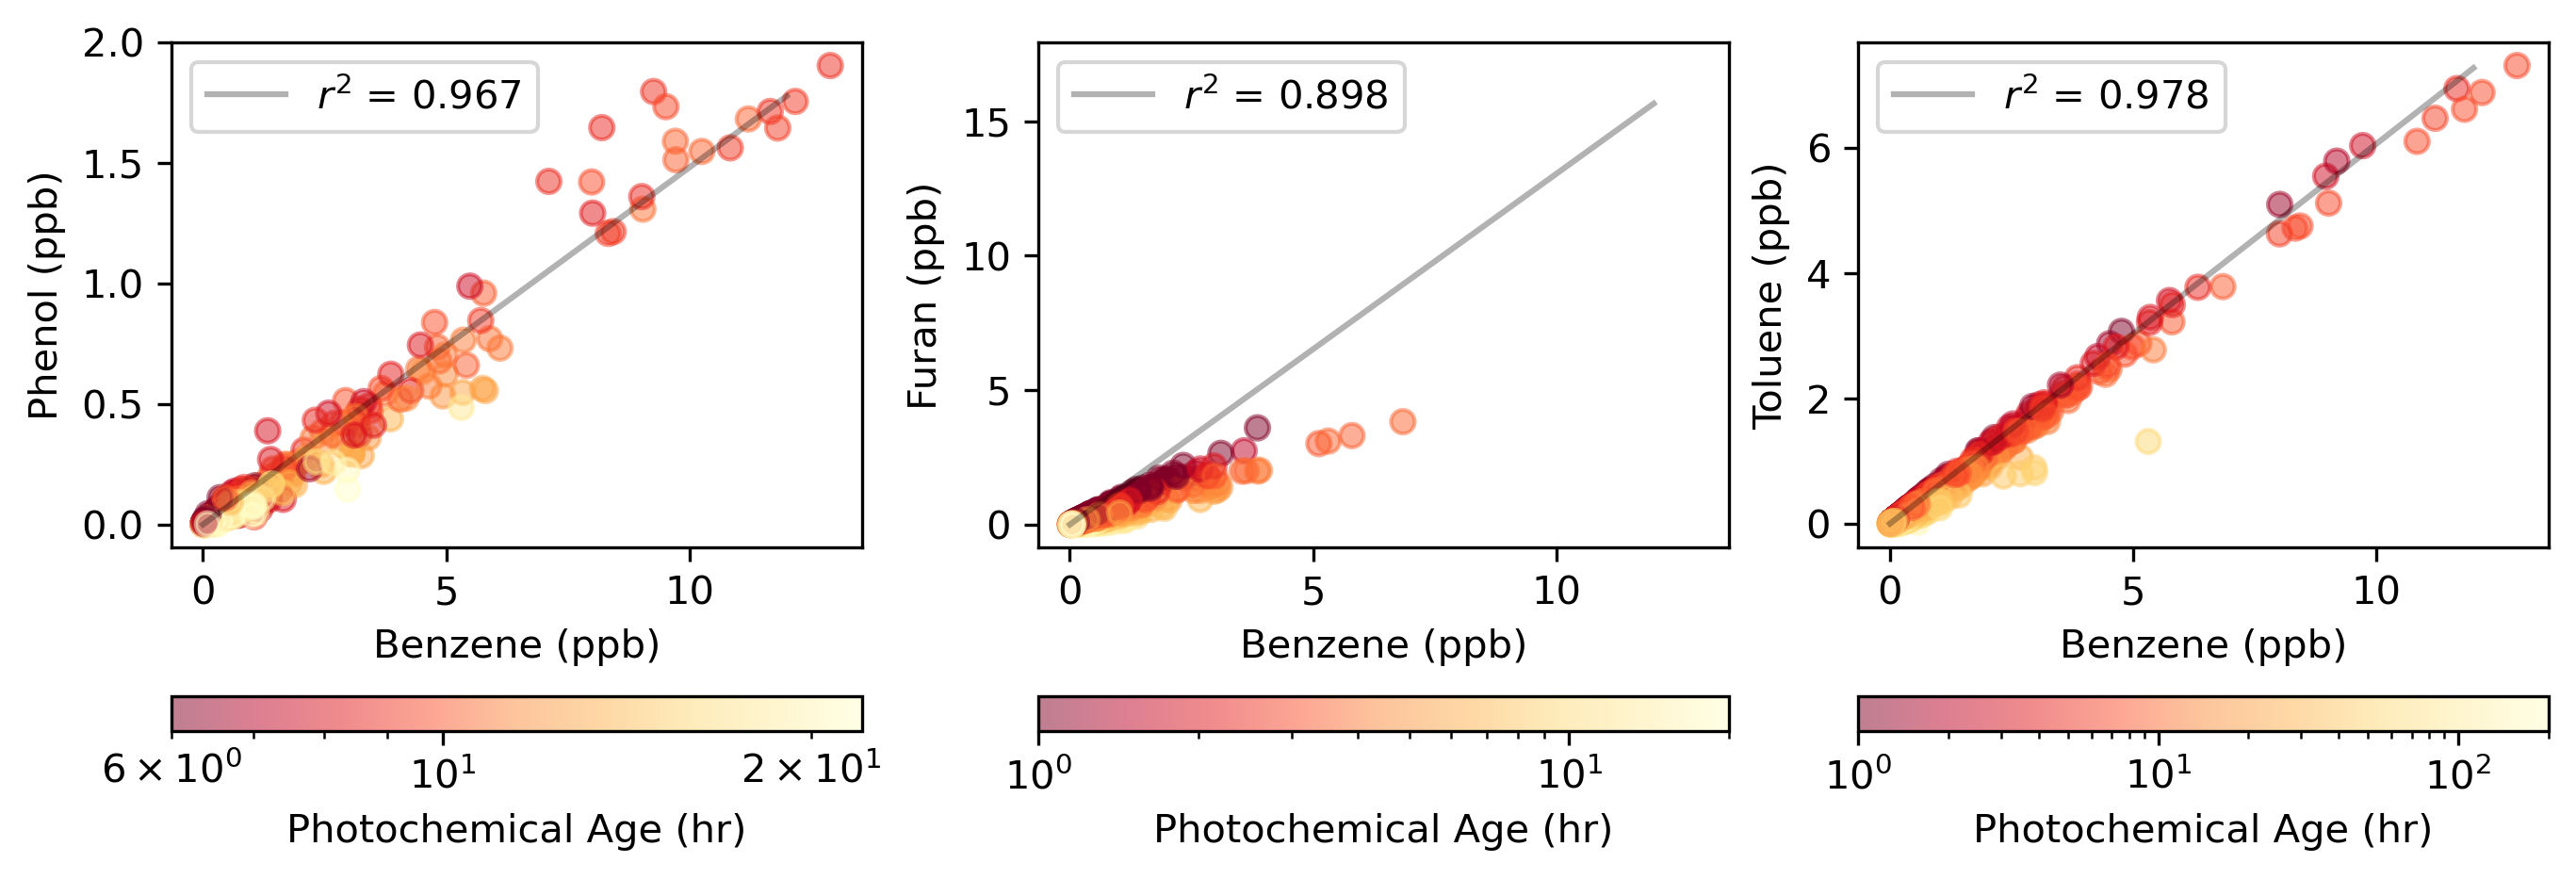

In [21]:
fire_df = df[df['regime']=='fire']

fig,ax = plt.subplots(figsize=(9,3), sharex=False, sharey=False,
        nrows=1, ncols=3,
        constrained_layout=True, dpi=300)

ax = ax.flatten()

p = ax[0].scatter(fire_df['Benzene']*1e-3, fire_df['Phenol']*1e-3, alpha=0.5, c=fire_df['age_phenol_benzene'], norm=matplotlib.colors.LogNorm(vmin=6, vmax=22), cmap='YlOrRd_r')
cax,kw = mpl.colorbar.make_axes(ax[0], location='bottom', pad=0.05, orientation='horizontal')
cbar = fig.colorbar(p, cax=cax, **kw)
cbar.set_label('Photochemical Age (hr)', fontsize=10)
# cbar.set_ticklabels(ticks, fontsize=8)
p = ax[1].scatter(fire_df['Benzene']*1e-3, fire_df['Furan']*1e-3, alpha=0.5, c=fire_df['age_furan_benzene'], norm=matplotlib.colors.LogNorm(vmin=1, vmax=20), cmap='YlOrRd_r')
cax,kw = mpl.colorbar.make_axes(ax[1], location='bottom', pad=0.05, orientation='horizontal')
cbar = fig.colorbar(p, cax=cax, **kw)
cbar.set_label('Photochemical Age (hr)', fontsize=10)
# cbar.set_ticklabels(ticks, fontsize=8)
p = ax[2].scatter(fire_df['Benzene']*1e-3, fire_df['Toluene']*1e-3, alpha=0.5, c=fire_df['age_toluene_benzene'], norm=matplotlib.colors.LogNorm(vmin=1, vmax=200), cmap='YlOrRd_r')
cax,kw = mpl.colorbar.make_axes(ax[2], location='bottom', pad=0.05, orientation='horizontal')
cbar = fig.colorbar(p, cax=cax, **kw)
cbar.set_label('Photochemical Age (hr)', fontsize=10)
# cbar.set_ticklabels(ticks, fontsize=8)

slope, r2 = rma_regression_slope(fire_df, 'Benzene', 'Phenol')
ax[0].plot(np.linspace(0,12,100), slope*np.linspace(0,12,100), label=r'$r^2$ = {}'.format(round(r2, 3)), color='k', alpha=0.3)

slope, r2 = rma_regression_slope(fire_df, 'Benzene', 'Furan')
ax[1].plot(np.linspace(0,12,100), slope*np.linspace(0,12,100), label=r'$r^2$ = {}'.format(round(r2, 3)), color='k', alpha=0.3)

slope, r2 = rma_regression_slope(fire_df, 'Benzene', 'Toluene')
ax[2].plot(np.linspace(0,12,100), slope*np.linspace(0,12,100), label=r'$r^2$ = {}'.format(round(r2, 3)), color='k', alpha=0.3)

for a in ax:
    a.set_xlabel(r'Benzene (ppb)',)
    a.legend()
ax[0].set_ylabel(r'Phenol (ppb)')
ax[1].set_ylabel(r'Furan (ppb)')
ax[2].set_ylabel(r'Toluene (ppb)')

#save figure as pdf
plt.savefig("../../figures/supfig_05.pdf", bbox_inches='tight', dpi=300)

### Figure S6

In [23]:
def photochemical_age_viz(measurements_df, X, Y, T, OH):
    """
    returns age in [s]
    """
    
    AX = eval(measurements_df.loc[measurements_df['Core_Name'] == X]['A'].values[0])
    nX = measurements_df.loc[measurements_df['Core_Name'] == X]['n'].values[0]
    BX = measurements_df.loc[measurements_df['Core_Name'] == X]['B'].values[0]
    EFX = measurements_df.loc[measurements_df['Core_Name'] == X]['EF'].values[0]
    
    AY = eval(measurements_df.loc[measurements_df['Core_Name'] == Y]['A'].values[0])
    nY = measurements_df.loc[measurements_df['Core_Name'] == Y]['n'].values[0]
    BY = measurements_df.loc[measurements_df['Core_Name'] == Y]['B'].values[0]
    EFY = measurements_df.loc[measurements_df['Core_Name'] == Y]['EF'].values[0]
    
    kX = bimolecular_rate_law(AX, nX, BX, T=T)
    kY = bimolecular_rate_law(AY, nY, BY, T=T)
    
    ER = EFX / EFY
    
    ratio = np.linspace(ER, 0, 1000)
    
    age = ( 1 / ( OH * (kX - kY ) ) * ( ( np.log(ER) ) -  ( np.log( ratio ) ) ) )
    
    return (age, ratio)

In [24]:
campaign_dict = {"FIREX":"#b71528", "WECAN":"#dc8904", "DC3":"#6a9c30", "ARCTAS":"#1f487e","ATom":"#824a5a"}

/tmp/ipykernel_354684/4051726230.py:23: RuntimeWarning: divide by zero encountered in log
  age = ( 1 / ( OH * (kX - kY ) ) * ( ( np.log(ER) ) -  ( np.log( ratio ) ) ) )


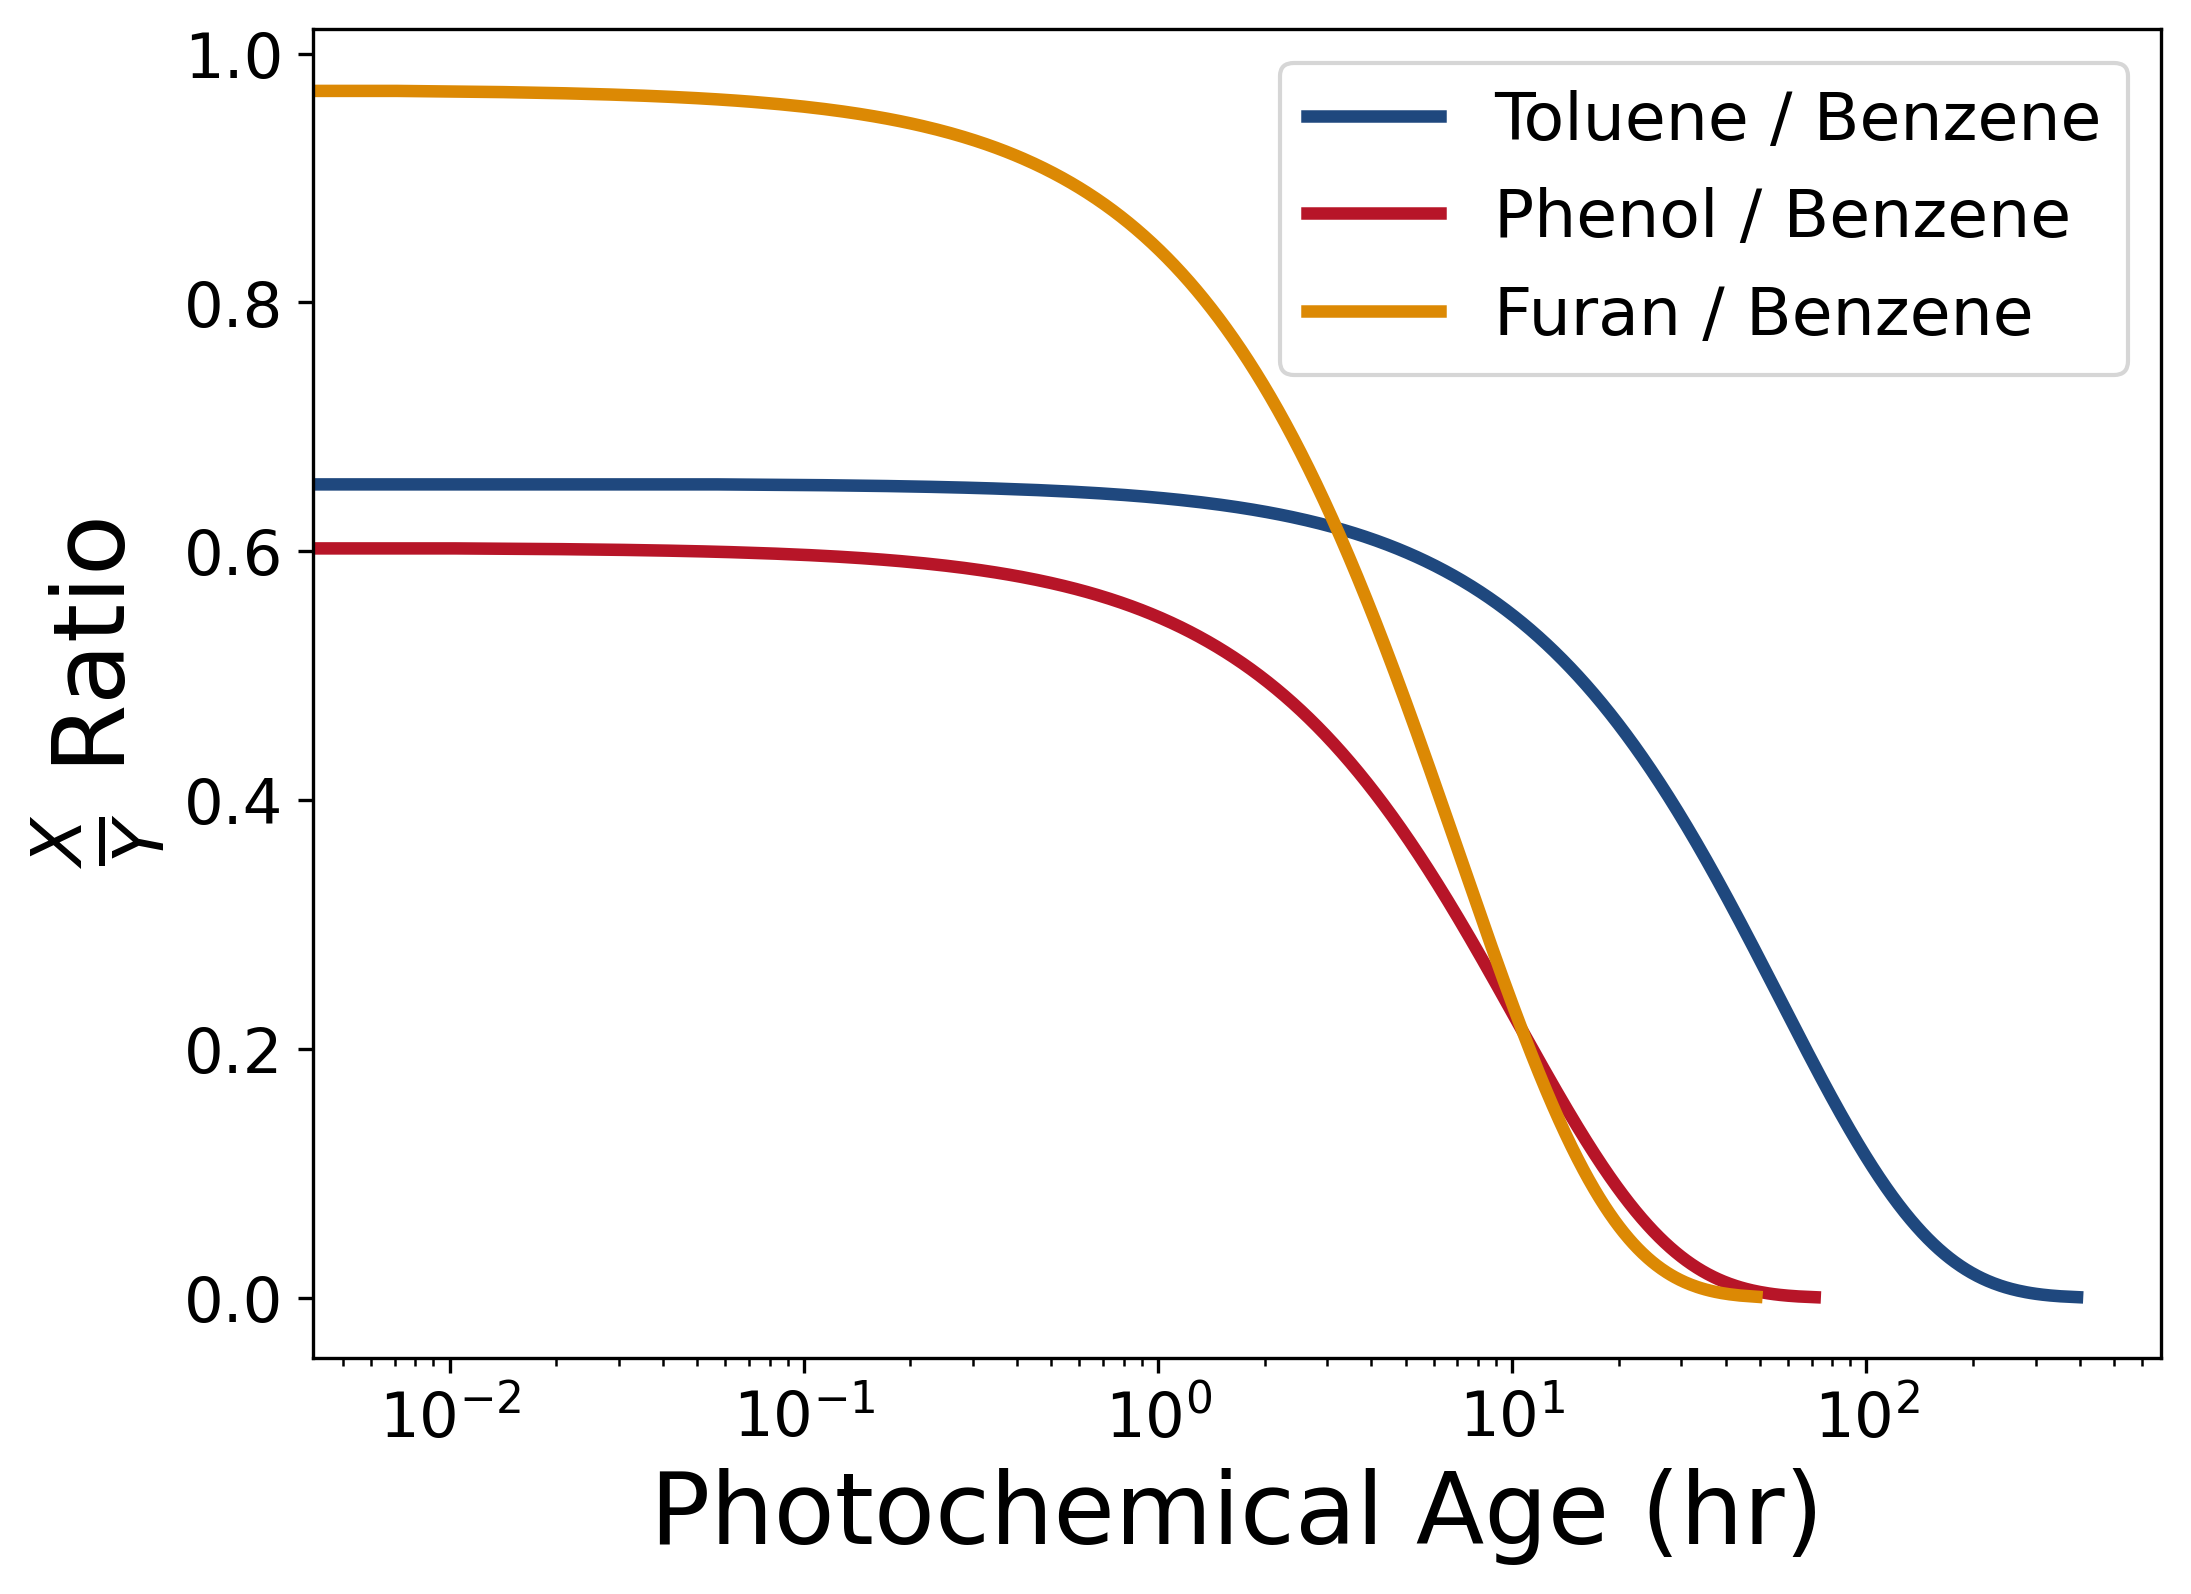

In [25]:
fig, ax = plt.subplots(figsize=(7.95, 5.75), dpi=300, )
tol_benz = photochemical_age_viz(firex_measurements_df, 'Toluene', 'Benzene', 298, 1e6)
ax.plot(tol_benz[0]/3600, tol_benz[1], label='Toluene / Benzene', color=campaign_dict['ARCTAS'], lw=3)
phen_benz = photochemical_age_viz(firex_measurements_df, 'Phenol', 'Benzene', 298, 1e6)
ax.plot(phen_benz[0]/3600, phen_benz[1], label='Phenol / Benzene', color=campaign_dict['FIREX'], lw=3)
# gly_benz = photochemical_age_viz('CHOCHO', 'Benzene', 298, 1e6)
# ax.plot(gly_benz[0]/3600, gly_benz[1], label='Glyoxal / Benzene')
furan_benz = photochemical_age_viz(firex_measurements_df, 'Furan', 'Benzene', 298, 1e6)
ax.plot(furan_benz[0]/3600, furan_benz[1], label='Furan / Benzene', color=campaign_dict['WECAN'], lw=3)
ax.legend(loc='upper right', fontsize=16)
ax.set_xscale('log')
ax.set_xlabel(r'Photochemical Age (hr)', fontsize=24)
ax.set_ylabel(r'$\frac{X}{Y}$ Ratio', fontsize=24)

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

#save figure as pdf
plt.savefig("../../figures/supfig_06.pdf", bbox_inches='tight', dpi=300)